# Introduction to Brian part 2: Synapses

*Modified by Kai Chen*

**Reference:** https://brian2.readthedocs.io/en/stable/

If you haven't yet read part 1: Neurons, go read that now.

As before we start by importing the Brian package and setting up matplotlib for IPython:

In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("https://raw.githubusercontent.com/NeoNeuron/professional-workshop-3/master/nma.mplstyle")

## The simplest Synapse

Once you have some neurons, the next step is to connect them up via synapses. We'll start out with doing the simplest possible type of synapse that causes an instantaneous change in a variable after a spike.

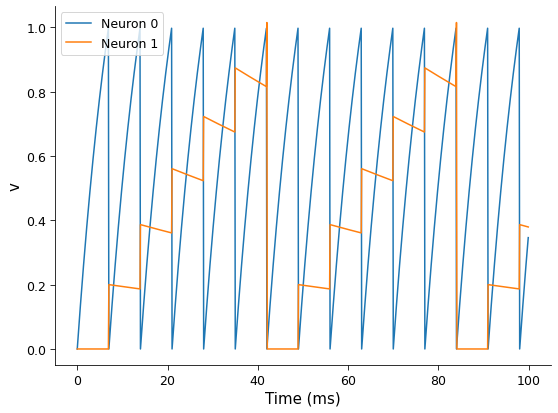

In [2]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v += 0.2')
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

There are a few things going on here. First of all, let's recap what is going on with the ``NeuronGroup``. We've created two neurons, each of which has the same differential equation but different values for parameters I and tau. Neuron 0 has ``I=2`` and ``tau=10*ms`` which means that is driven to repeatedly spike at a fairly high rate. Neuron 1 has ``I=0`` and ``tau=100*ms`` which means that on its own - without the synapses - it won't spike at all (the driving current I is 0). You can prove this to yourself by commenting out the two lines that define the synapse.

Next we define the synapses: ``Synapses(source, target, ...)`` means that we are defining a synaptic model that goes from ``source`` to ``target``. In this case, the source and target are both the same, the group ``G``. The syntax ``on_pre='v += 0.2'`` means that when a spike occurs in the presynaptic neuron (hence ``on_pre``) it causes an instantaneous change on postsynaptic neuron to happen ``v += 0.2``. So in total, what this model says is that whenever two neurons in G are connected by a synapse, when the source neuron fires a spike the target neuron will have its value of ``v`` increased by 0.2.

However, at this point we have only defined the synapse model, we haven't actually created any synapses. The next line ``S.connect(i=0, j=1)`` creates a synapse from neuron 0 to neuron 1.

## Adding a weight

In the previous section, we hard coded the weight of the synapse to be the value 0.2, but often we would to allow this to be different for different synapses. We do that by introducing synapse equations.

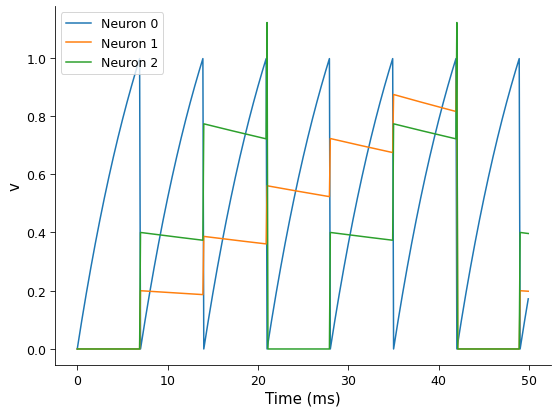

In [3]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, 'w : 1', on_pre='v += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

This example behaves very similarly to the previous example, but now there's a synaptic weight variable ``w``. The string ``'w : 1'`` is an equation string, precisely the same as for neurons, that defines a single dimensionless parameter ``w``. We changed the behaviour on a spike to ``on_pre='v_post += w'`` now, so that each synapse can behave differently depending on the value of ``w``. To illustrate this, we've made a third neuron which behaves precisely the same as the second neuron, and connected neuron 0 to both neurons 1 and 2. We've also set the weights via ``S.w = 'j*0.2'``. When ``i`` and ``j`` occur in the context of synapses, ``i`` refers to the source neuron index, and ``j`` to the target neuron index. So this will give a synaptic connection from 0 to 1 with weight ``0.2=0.2*1`` and from 0 to 2 with weight ``0.4=0.2*2``.

## Introducing a delay

So far, the synapses have been instantaneous, but we can also make them act with a certain delay.

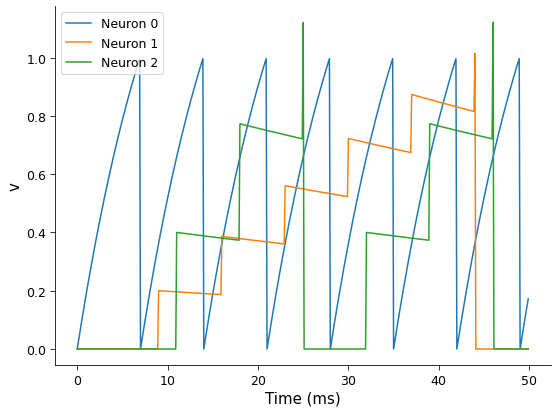

In [4]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'
S.delay = 'j*2*ms'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

As you can see, that's as simple as adding a line ``S.delay = 'j*2*ms'`` so that the synapse from 0 to 1 has a delay of 2 ms, and from 0 to 2 has a delay of 4 ms.

## More complex connectivity

So far, we specified the synaptic connectivity explicitly, but for larger networks this isn't usually possible. For that, we usually want to specify some condition.

In [5]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)

Here we've created a dummy neuron group of N neurons and a dummy synapses model that doens't actually do anything just to demonstrate the connectivity. The line ``S.connect(condition='i!=j', p=0.2)`` will connect all pairs of neurons ``i`` and ``j`` with probability 0.2 as long as the condition ``i!=j`` holds. So, how can we see that connectivity? Here's a little function that will let us visualise it.

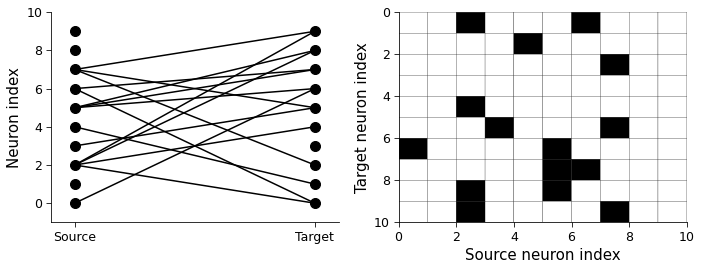

In [6]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    ax2 = plt.subplot(122)
    S_mat = np.ones((Nt, Ns))
    S_mat[S.j, S.i] = 0
    ax2.pcolor(S_mat, cmap='gray', edgecolor='k')
    ax2.invert_yaxis()
    ax2.set_xlabel('Source neuron index')
    ax2.set_ylabel('Target neuron index')
    
visualise_connectivity(S)

There are two plots here. On the left hand side, you see a vertical line of circles indicating source neurons on the left, and a vertical line indicating target neurons on the right, and a line between two neurons that have a synapse. On the right hand side is another way of visualising the same thing. Here each black dot is a synapse, with x value the source neuron index, and y value the target neuron index.

Let's see how these figures change as we change the probability of a connection:

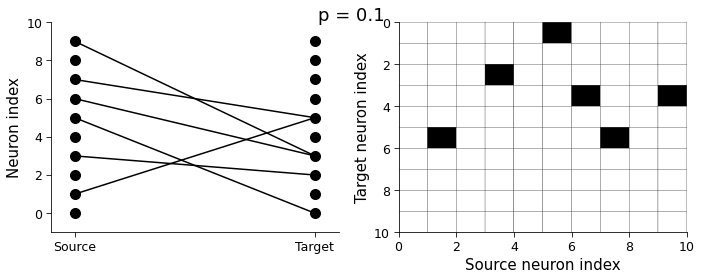

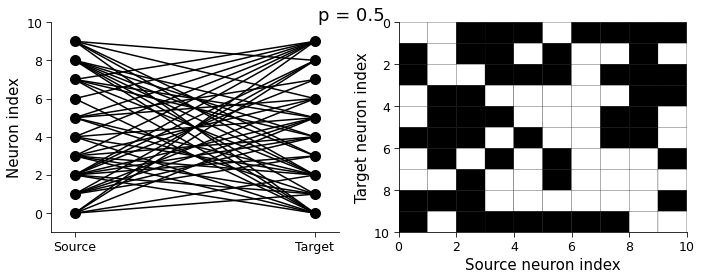

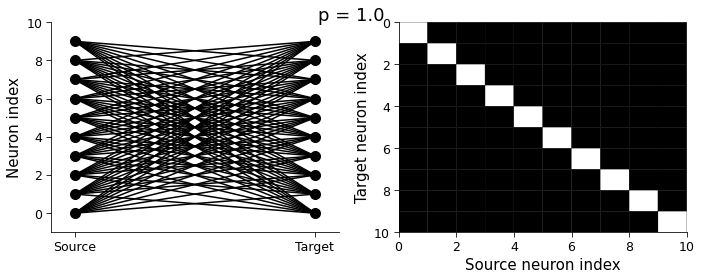

In [7]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = '+str(p))

And let's see what another connectivity condition looks like. This one will only connect neighbouring neurons.

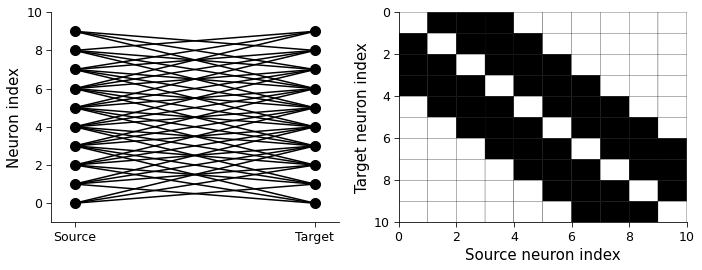

In [8]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(condition='abs(i-j)<4 and i!=j')
visualise_connectivity(S)

Try using that cell to see how other connectivity conditions look like.

You can also use the generator syntax to create connections like this more efficiently. In small examples like this, it doesn't matter, but for large numbers of neurons it can be much more efficient to specify directly which neurons should be connected than to specify just a condition. Note that the following example uses `skip_if_invalid` to avoid errors at the boundaries (e.g. do not try to connect the neuron with index 1 to a neuron with index -2).

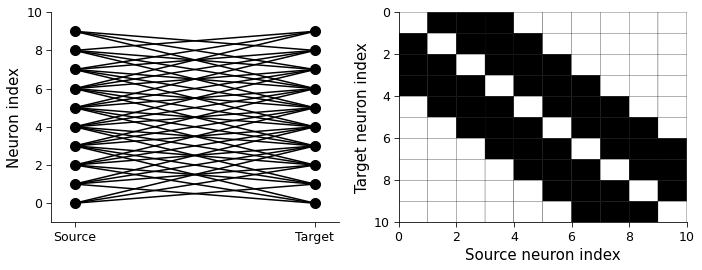

In [9]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(j='k for k in range(i-3, i+4) if i!=k', skip_if_invalid=True)
visualise_connectivity(S)

If each source neuron is connected to precisely one target neuron (which would be normally used with two separate groups of the same size, not with identical source and target groups as in this example), there is a special syntax that is extremely efficient. For example, 1-to-1 connectivity looks like this:

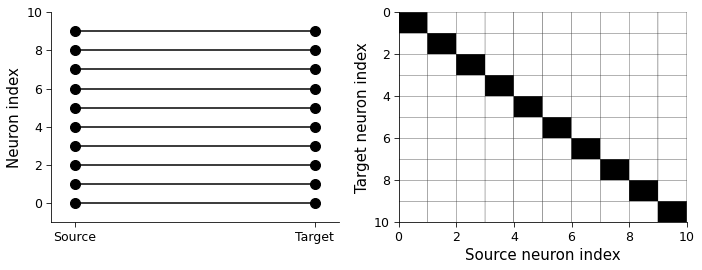

In [10]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(j='i')
visualise_connectivity(S)

You can also do things like specifying the value of weights with a string. Let's see an example where we assign each neuron a spatial location and have a distance-dependent connectivity function. We visualise the weight of a synapse by the size of the marker.

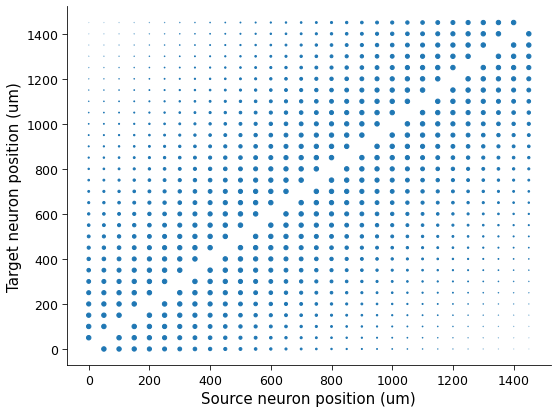

In [11]:
start_scope()

N = 30
neuron_spacing = 50*umetre
width = N/4.0*neuron_spacing

# Neuron has one variable x, its position
G = NeuronGroup(N, 'x : metre')
G.x = 'i*neuron_spacing'

# All synapses are connected (excluding self-connections)
S = Synapses(G, G, 'w : 1')
S.connect(condition='i!=j')
# Weight varies with distance
S.w = 'exp(-(x_pre-x_post)**2/(2*width**2))'

scatter(S.x_pre/um, S.x_post/um, S.w*20)
xlabel('Source neuron position (um)')
ylabel('Target neuron position (um)');

## End of tutorial